In this project, we recall our web scraping and perform clustering. We are testing if clustering have a good grouping power. We try to get data of few cuisines. 

PS: Follow this project with the corresponding appendix 

In [1]:
#First, import libraries as needed
import string
from lxml import html
import requests

Altogether we have 4 different type of groups. Here we are trying to cluster south-east asian (the first four) and asian lunch/buffet (the next four after that), scandinavian buffet(next four after asian) and cafe (Final four).  Lets see what result we get.

We are this time scraping review data from Yelp site. 

In [2]:
cuisines = ['mountain-helsinki-2',
'mount-everest-helsinki-2',
'india-house-helsinki',
'samrat-helsinki-2',

'lemon-grass-helsinki',
'korea-house-helsinki',
'hoku-helsinki',
'new-bamboo-center-helsinki',

'konstan-möljä-helsinki',
'ravintola-kuukuu-helsinki-2',
'sea-horse-helsinki',
'pompier-helsinki',

'karl-fazer-café-helsinki-2',
'johan-ja-nyström-helsinki-2',
'sävy-helsinki-2',
'good-life-coffee-helsinki']

#create a base url that will iterate later with the unique url segments we have in our CUISINES list
base_urls = [ 'http://www.yelp.com/biz/%s' % s for s in cuisines]
reviews_per_page = 20 # Number of reviews we want for each page
order_sequence = range(0, (reviews_per_page+1), 40) #range to grab reviews from each page

In [3]:
import string
i=0 
#start iteration of urls using the base_url and unique segments
for url in base_urls:
    for os in order_sequence:
        page = requests.get(url + ("?start=%s" % os))
        tree = html.fromstring(page.text)
        
        # this will make a list of all the reviews
        reviews = tree.xpath('//p[@itemprop="description"]/text()')
        review_list = []
        for review in reviews:
            rev_list = "".join(filter(lambda x: x in string.printable, review)) # type is str
            rev_list = rev_list.replace(",",":")
            rev_list = rev_list.replace("\'","")
            review_list.append(rev_list) 
        
    # this will make one text file for each restaurant with their reviews
    with open(str(cuisines[i])+".txt", 'w') as f:
        f.write("\n".join(map(lambda x: str(x), review_list)))
        i+=1
        f.close()

In [16]:
with open('../restaurant_cuisines.txt', 'w', encoding='ISO 8859-1') as restaurant_file:
    for item in cuisines:
        restaurant_file.writelines("%s\n" % item)
    

In [17]:

#Start making a dendrogram that will show similarities of the restaurants
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import glob

In [18]:
# read file (reading with "With" closes the file automatically)
with open('../restaurant_cuisines.txt', encoding='ISO 8859-1') as res:

    # read the file and then splitlines removes \n and then converts to list
    hel_restaurants = res.read().splitlines()
    #print(hel_restaurants)

# add suffix .txt so that it can be compared with valid text files (using glob)
pre_hel_restaurants = [x+'.txt' for x in hel_restaurants]
#print(pre_hel_restaurants)

# list for storing all files review data 
all_restaurants_reviews = []


# use the glob for reading each files in the directory with a file pattern of .txt
for file in glob.glob('*.txt'):      
    with open(file, encoding='ISO 8859-1') as readFile:
        all_restaurants_reviews.append(readFile.read().replace("\n", " "))
#print(all_files_reviews)

In [19]:
cleaned_rev = []
for text in all_restaurants_reviews:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    cleaned_rev.append(text)
    # Check the result

In [20]:
stopwords = nltk.corpus.stopwords.words('english')

# I will stem the words to reduce the feature set

from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

# Define a function that will tokenize and stem text

def tokenize_and_lemmatize(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    lemms = [wnl.lemmatize(t) for t in filtered_tokens]
    return lemms

totalvocab_lemmatized = []

for s in cleaned_rev:
    allwords_lemmatize = tokenize_and_lemmatize(s)
    totalvocab_lemmatized.extend(allwords_lemmatize)

#### N-Gram (Also see the appendix section to understand it properly)

N-Gram in NLP refers to a sequence of words (or letters) in a sentence. It is used in NLP to identify letters or words that frequently appear adjacent to one another. N-Gram can be used for predictive text input (in your mobile keypad,do u observe some magical word predictions ?) and in Speech-to-Text generation as well (try converting your speech into text using google assistant).

Try this fun game:

- Try typing any word like this/that/his/her/I etc on your mobile/tablet device and then just follow the suggestion. See if you end up with a meaningful sentence finally. 

Now time to think:

- Do you think n-grams could be used for sentiment analysis ? Here we are going to use it in case of clustering (Why would it improve our results ?). 

In [21]:
#define vectorizer parameters
from sklearn.feature_extraction.text import TfidfVectorizer

#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_lemmatize, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_rev) #fit the vectorizer to clean reviews

print(tfidf_matrix.shape)

C:\Users\tranq\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Wall time: 306 ms
(16, 372)


In [22]:
terms = tfidf_vectorizer.get_feature_names()
terms[:10]

['absolutely',
 'actually',
 'add',
 'almond',
 'amazing',
 'ambiance',
 'appetizer',
 'area',
 'ask',
 'asked']

In [23]:
print("Total vocabulary: ", len(totalvocab_lemmatized), "Terms used in the TF-IDF matrix: ", len(terms))


Total vocabulary:  17886 Terms used in the TF-IDF matrix:  372


In [24]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [25]:
restnames = np.array(hel_restaurants)
#len(restnames)

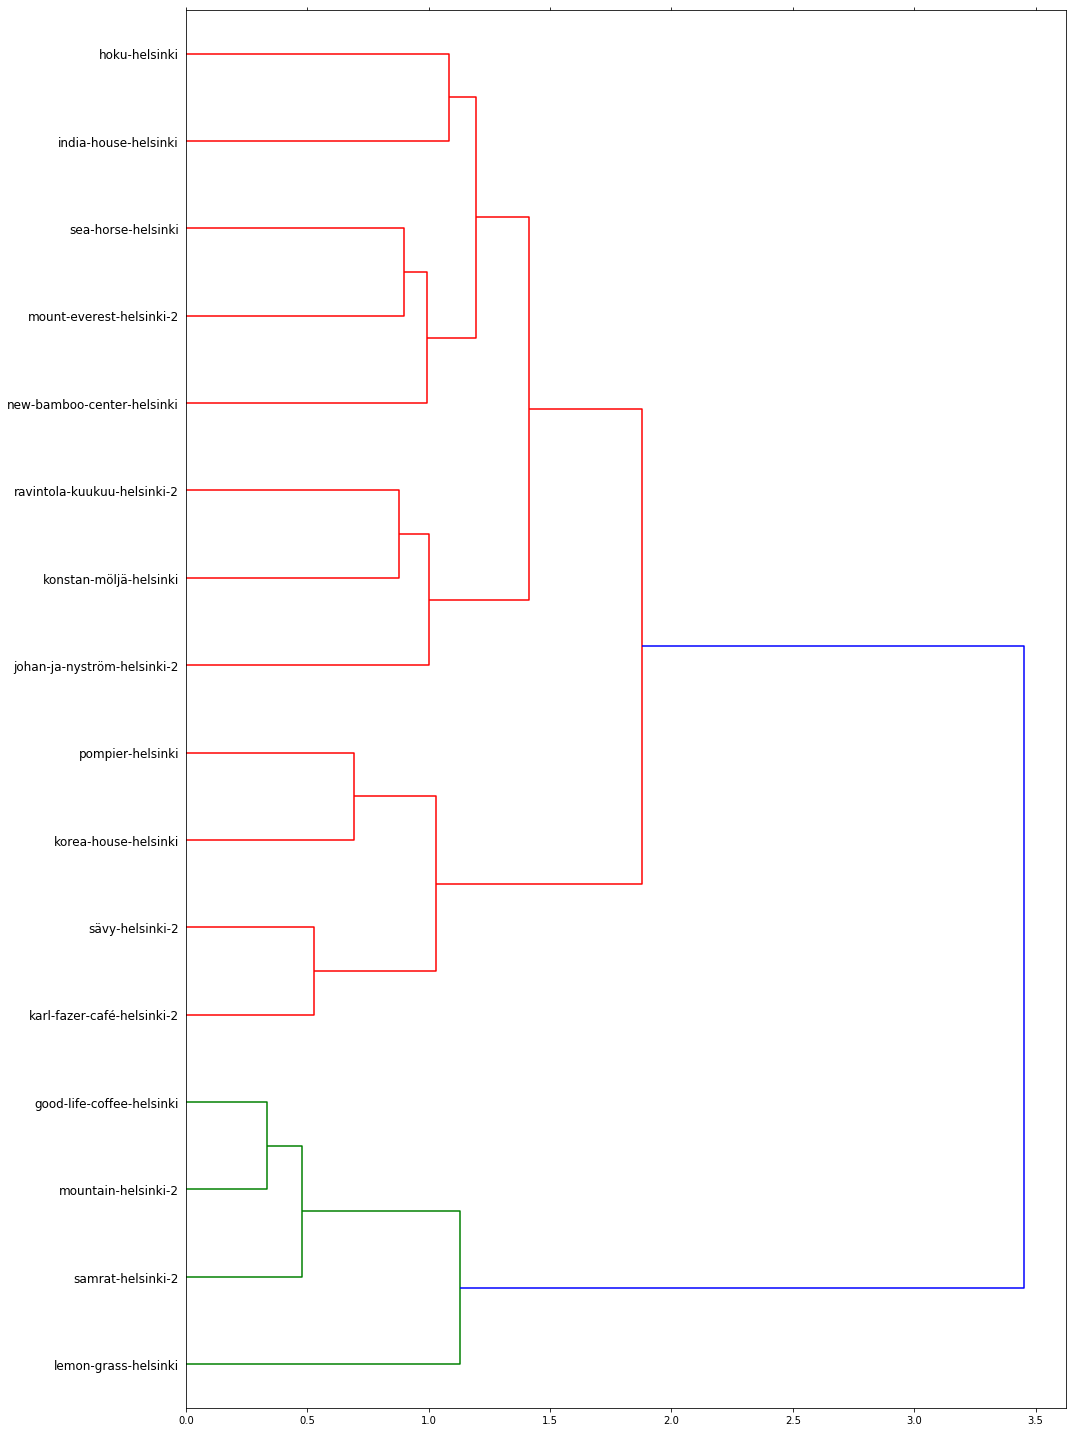

<Figure size 432x288 with 0 Axes>

In [26]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=restnames);

#Check out the documentation and the parameters used. Feel free to play with them
#https://matplotlib.org/api/_as_gen/matplotlib.pyplot.tick_params.html
plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

plt.show()
#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) 
#save figure as ward_clusters


#### Do restaurantas offering the same cuisine cluster together? 

Based on our dendogram, it appears that restaurants offering the same cuisine for the most part cluster together. However, there is one exception. A dendogram looks at distances between data points on the y axis, which is based upon height and proximity. It first looks at one point closer to another, and then determines the distance between other seperate clusters. Here, we can scroll down to the pakastani/indian restaurants in green, and see that Nordic Preserves Fish and Wildlife Company cluster together in the same group, over being grouped with the other scandinavian restaurants. This is very interesting because these cuisines would probably be considered very different from each other. In addition, the clustering with the korean restaurants also appears to have some form of proximity/similarities, with the scandinavian restaurants. This is depicted in the bigger blue cluster connecting the two clusters together (macro-cluster). Overall, however, the sames cuisines cluster together.

Task: Try also scraping restaurants from four countries (four in total, one from each unique country) from this list:
- Turkey, Iraq, Iran, Georgia, Syria, Egypt, Greece

You can use London or New York as city. Thus you can have more text data that the algorithm can work on and we may have better result. Observe the result. After that answer: Why did I select the above countries only.         
        

Reference:

https://github.com/chantelmariediaz/Scraping-Yelp-with-Python/blob/master/Clustering%2BCuisines%2BYelp%2BScrape%2BReviews%2B-%2BChantel%2BDiaz.ipynb    

Further, You might also try following the article on how to implement recommendation system:

https://towardsdatascience.com/build-your-own-clustering-based-recommendation-engine-in-15-minutes-bdddd591d394 

We have already implemented a recommender system in preceeding exercise, which performs better recommendation than clustering algorithms. But you may try implementing a recommender system of your own using clustering and figure out which performs better. 

#### Where to go from Here ? 


Now I am sure that you must have reached a level that you can follow this article and try something meaningful project like this by yourself :

http://brandonrose.org/clustering

Go through this article as well. Dont bother about its implementation and some extra data analysis they are doing using SAS. Just go through the article quickly and see what interesting things can be done using text mining. 

https://www.researchgate.net/publication/279530493_Alien_Nation_Text_Analysis_of_UFO_Sightings_in_the_US_Using_SASR_Enterprise_Miner_131_by_Pradeep_Reddy_Kalakota_Naresh_Abburi_Zabiulla_Mohammed_and_Goutam_Chakraborty